# House Price Prediction Project
## Ben Belnap (003177064)

This notebook implements a machine learning solution to predict house prices using the Ames Housing Dataset. The project follows the CRISP-DM methodology and aims to provide accurate home value estimates for a mortgage company.

## 1. Setup and Required Libraries

Import all necessary libraries for data analysis, modeling, and visualization.

In [15]:
# Setup Python path
import os
import sys
notebook_dir = os.path.abspath(os.getcwd())  # Get the notebook's directory
project_root = os.path.dirname(notebook_dir)  # Get the project root directory
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"Added to Python path: {project_root}")

# Data manipulation and analysis
import pandas as pd
import numpy as np
import polars as pl

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom modules
from src.data_preprocessing import check_data_quality, remove_outliers, prepare_data
from src.model_utils import get_default_models, debug_model_performance
from src.evaluation_utils import evaluate_model, plot_predictions

# Settings
plt.style.use('seaborn-v0_8')  
sns.set_theme()  # Using seaborn's default theme
%matplotlib inline

Added to Python path: d:\Repos\House-Price-Prediction-Machine-Learning


## 2. Data Understanding

In this section, we will load and explore the Ames Housing Dataset. We'll analyze its structure, generate summary statistics, and visualize key relationships.

In [16]:
# Load the dataset with error handling
try:
    df = pd.read_csv('../data/amesHousing.csv')
    print("Dataset successfully loaded!")
    print("\nDataset Shape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    
    # Check for missing values
    missing_values = df.isnull().sum()
    print("\nColumns with missing values:")
    print(missing_values[missing_values > 0])
    
    # Display basic statistics
    print("\nNumerical columns statistics:")
    print(df.describe())
except FileNotFoundError:
    print("Error: Dataset file not found. Please make sure 'ames_housing.csv' is in the data directory.")
except pd.errors.EmptyDataError:
    print("Error: The dataset file is empty.")
except pd.errors.ParserError:
    print("Error: Unable to parse the CSV file. Please check if it's a valid CSV format.")
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")

Dataset successfully loaded!

Dataset Shape: (2930, 82)

First few rows:
   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

 

## 3. Data Preparation

Here we will clean the data, handle missing values, remove outliers, and prepare features for modeling.

In [17]:
# Data cleaning functions
check_data_quality(df)

=== Data Quality Report ===

Data Types:
object     43
int64      28
float64    11
Name: count, dtype: int64

Columns with missing values:
Lot Frontage       490
Alley             2732
Mas Vnr Type      1775
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64

Number of duplicate rows: 0

Checking numerical columns for invalid values...


{'missing': Order               0
 PID                 0
 MS SubClass         0
 MS Zoning           0
 Lot Frontage      490
                  ... 
 Mo Sold             0
 Yr Sold             0
 Sale Type           0
 Sale Condition      0
 SalePrice           0
 Length: 82, dtype: int64,
 'duplicates': np.int64(0)}

### Missing Value Analysis

Let's analyze our missing values in detail before deciding how to handle them:
1. Calculate the percentage of missing values per column
2. Understand the nature of missingness (Missing Completely at Random, Missing at Random, or Missing Not at Random)
3. Make informed decisions based on domain knowledge

Columns with missing values (sorted by percentage):
            Column  Missing %
73         Pool QC  99.556314
75    Misc Feature  96.382253
7            Alley  93.242321
74           Fence  80.477816
26    Mas Vnr Type  60.580205
58    Fireplace Qu  48.532423
4     Lot Frontage  16.723549
64     Garage Qual   5.426621
60   Garage Yr Blt   5.426621
65     Garage Cond   5.426621
61   Garage Finish   5.426621
59     Garage Type   5.358362
33   Bsmt Exposure   2.832765
36  BsmtFin Type 2   2.764505
31       Bsmt Qual   2.730375
32       Bsmt Cond   2.730375
34  BsmtFin Type 1   2.730375
27    Mas Vnr Area   0.784983
48  Bsmt Full Bath   0.068259
49  Bsmt Half Bath   0.068259
39   Total Bsmt SF   0.034130
35    BsmtFin SF 1   0.034130
37    BsmtFin SF 2   0.034130
63     Garage Area   0.034130
62     Garage Cars   0.034130
38     Bsmt Unf SF   0.034130
43      Electrical   0.034130


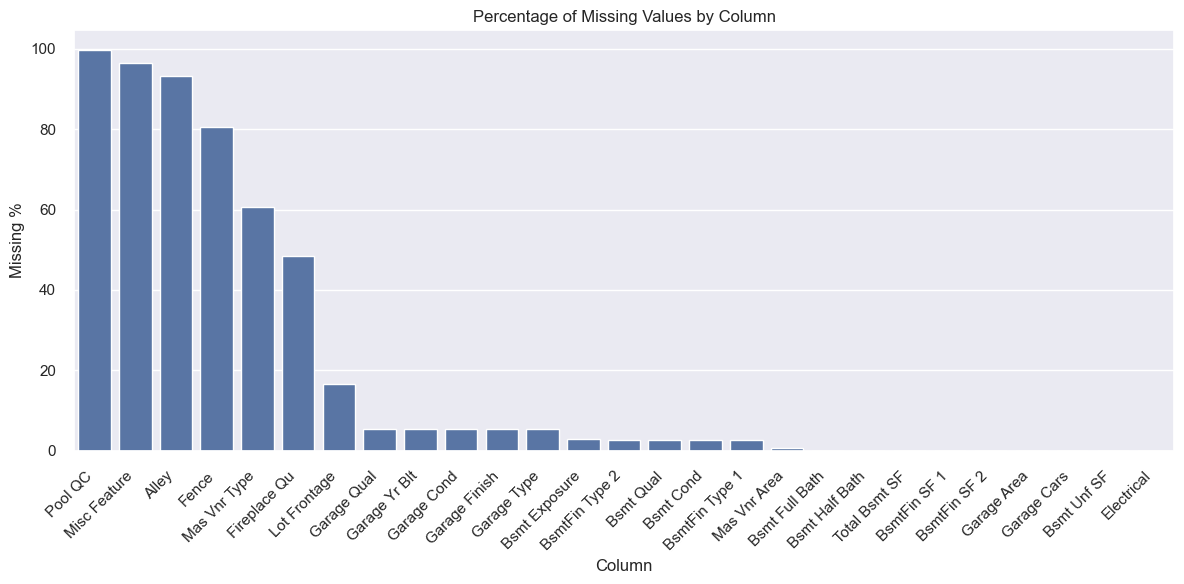


Recommended handling strategies:

Columns to consider dropping (>30% missing):
['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Mas Vnr Type', 'Fireplace Qu']

Columns needing careful consideration (10-30% missing):
['Lot Frontage']

Columns safe for standard imputation (<10% missing):
['Garage Qual', 'Garage Yr Blt', 'Garage Cond', 'Garage Finish', 'Garage Type', 'Bsmt Exposure', 'BsmtFin Type 2', 'Bsmt Qual', 'Bsmt Cond', 'BsmtFin Type 1', 'Mas Vnr Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Total Bsmt SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Garage Area', 'Garage Cars', 'Bsmt Unf SF', 'Electrical']

Analyzing relationship between missingness and Sale Price:

Lot Frontage:
Average Sale Price (missing): $184,263.44
Average Sale Price (not missing): $180,099.74
Difference: $4,163.70


In [18]:
# Calculate percentage of missing values per column
missing_percentages = (df.isnull().sum() / len(df)) * 100
missing_stats = pd.DataFrame({
    'Column': missing_percentages.index,
    'Missing %': missing_percentages.values
}).sort_values('Missing %', ascending=False)

print("Columns with missing values (sorted by percentage):")
print(missing_stats[missing_stats['Missing %'] > 0])

# Visualize missing value patterns
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_stats[missing_stats['Missing %'] > 0]['Column'],
            y=missing_stats[missing_stats['Missing %'] > 0]['Missing %'])
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Missing Values by Column')
plt.tight_layout()
plt.show()

# Define thresholds for different handling strategies
HIGH_MISSING = 30  # If more than 30% missing, consider dropping the column
MODERATE_MISSING = 10  # If between 10-30% missing, need careful consideration
LOW_MISSING = 5  # If less than 5% missing, can impute with median/mode

# Categorize columns based on missing percentages
high_missing_cols = missing_stats[missing_stats['Missing %'] > HIGH_MISSING]['Column'].tolist()
moderate_missing_cols = missing_stats[(missing_stats['Missing %'] <= HIGH_MISSING) & 
                                    (missing_stats['Missing %'] > MODERATE_MISSING)]['Column'].tolist()
low_missing_cols = missing_stats[(missing_stats['Missing %'] <= MODERATE_MISSING) & 
                                (missing_stats['Missing %'] > 0)]['Column'].tolist()

print("\nRecommended handling strategies:")
print(f"\nColumns to consider dropping (>{HIGH_MISSING}% missing):")
print(high_missing_cols)
print(f"\nColumns needing careful consideration ({MODERATE_MISSING}-{HIGH_MISSING}% missing):")
print(moderate_missing_cols)
print(f"\nColumns safe for standard imputation (<{MODERATE_MISSING}% missing):")
print(low_missing_cols)

# For numeric columns with moderate missing values, let's check if missingness is related to the target variable
print("\nAnalyzing relationship between missingness and Sale Price:")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in [c for c in moderate_missing_cols if c in numeric_cols]:
    missing_mask = df[col].isnull()
    if missing_mask.any():
        avg_price_missing = df[missing_mask]['SalePrice'].mean()
        avg_price_not_missing = df[~missing_mask]['SalePrice'].mean()
        print(f"\n{col}:")
        print(f"Average Sale Price (missing): ${avg_price_missing:,.2f}")
        print(f"Average Sale Price (not missing): ${avg_price_not_missing:,.2f}")
        print(f"Difference: ${abs(avg_price_missing - avg_price_not_missing):,.2f}")

In [19]:
# Apply data preparation using our utility functions
df_cleaned = prepare_data(df.copy())

check_data_quality(df_cleaned)

Starting data preparation...

Removing outliers from SalePrice...
Removed 83 outliers (2.83% of data)

Handling missing values...
Remaining missing values: 0

Data preparation completed!

Final dataset shape: (2847, 82)
=== Data Quality Report ===

Data Types:
object     43
int64      28
float64    11
Name: count, dtype: int64

No missing values found!

Number of duplicate rows: 0

Checking numerical columns for invalid values...


d:\Repos\House-Price-Prediction-Machine-Learning\src\data_preprocessing.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
d:\Repos\House-Price-Prediction-Machine-Learning\src\data_preprocessing.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

{'missing': Order             0
 PID               0
 MS SubClass       0
 MS Zoning         0
 Lot Frontage      0
                  ..
 Mo Sold           0
 Yr Sold           0
 Sale Type         0
 Sale Condition    0
 SalePrice         0
 Length: 82, dtype: int64,
 'duplicates': np.int64(0)}

## 4. Model Development

We will implement and train multiple models, including Random Forest and XGBoost.

In [20]:
# Initialize models using our utility function
models = get_default_models()

### Data Split and Feature Preparation

Before training our models, we need to:
1. Separate features (X) from target variable (y)
2. Split data into training and test sets
3. Scale numerical features to ensure all features contribute equally to the model

In [21]:
# Separate features and target
X = df_cleaned.drop('SalePrice', axis=1)  # All columns except SalePrice
y = df_cleaned['SalePrice']

# Get list of numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print("Feature Information:")
print(f"Numerical columns: {len(numerical_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print(f"\nShape after creating dummy variables: {X.shape}")

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # Use 80% for training, 20% for testing
    random_state=42  # For reproducibility
)

print("\nData Split Summary:")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set price statistics:")
print(y_train.describe())

Feature Information:
Numerical columns: 38
Categorical columns: 43

Shape after creating dummy variables: (2847, 262)

Data Split Summary:
Training set shape: (2277, 262)
Test set shape: (570, 262)

Training set price statistics:
count      2277.000000
mean     173352.102328
std       64497.411119
min       34900.000000
25%      128600.000000
50%      159500.000000
75%      208300.000000
max      380000.000000
Name: SalePrice, dtype: float64


In [ ]:
# Model validation and debugging functions
from sklearn.metrics import mean_absolute_error, r2_score

def debug_model_performance(model, X_train, X_test, y_train, y_test, model_name):
    """Debug model performance and print detailed analysis"""
    print(f"=== {model_name} Debug Report ===")
    
    # Training performance
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Testing performance
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("\nPerformance Metrics:")
    print(f"Training MAE: ${train_mae:,.2f}")
    print(f"Testing MAE: ${test_mae:,.2f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    
    # Check for overfitting
    print("\nOverfitting Analysis:")
    mae_diff = abs(train_mae - test_mae)
    r2_diff = abs(train_r2 - test_r2)
    print(f"MAE difference (train-test): ${mae_diff:,.2f}")
    print(f"R² difference (train-test): {r2_diff:.4f}")
    
    if mae_diff > 10000 or r2_diff > 0.1:
        print("WARNING: Possible overfitting detected!")
        
    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        print("\nTop 10 Important Features:")
        importances = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        print(importances.head(10))
        
    print('\n')
    return {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

# Train each model
for model_name, model in models.items():
    model.fit(X_train, y_train)  
    # debug_model_performance(model, X_train, X_test, y_train, y_test, model_name)

=== Random Forest Debug Report ===

Performance Metrics:
Training MAE: $5,516.85
Testing MAE: $14,375.95
Training R²: 0.9835
Testing R²: 0.8942

Overfitting Analysis:
MAE difference (train-test): $8,859.11
R² difference (train-test): 0.0893

Top 10 Important Features:
          feature  importance
5    Overall Qual    0.552657
17    Gr Liv Area    0.124304
28    Garage Area    0.040217
13  Total Bsmt SF    0.035097
14     1st Flr SF    0.031354
27    Garage Cars    0.029912
10   BsmtFin SF 1    0.022589
7      Year Built    0.013836
4        Lot Area    0.013154
1             PID    0.012530


=== XGBoost Debug Report ===

Performance Metrics:
Training MAE: $1,891.38
Testing MAE: $13,951.27
Training R²: 0.9984
Testing R²: 0.9020

Overfitting Analysis:
MAE difference (train-test): $12,059.90
R² difference (train-test): 0.0964

Top 10 Important Features:
                feature  importance
5          Overall Qual    0.306363
225  Garage Type_Detchd    0.095750
27          Garage Cars    

## 5. Model Evaluation

We will evaluate our models using mean absolute error and other metrics.

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display model performance metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nModel: {model_name}")
    print(f"Mean Absolute Error: ${mae:,.2f}")
    print(f"Root Mean Squared Error: ${rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

# Evaluate each model on both training and test sets
results = {}
for model_name, model in models.items():
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate on training set
    print("\nTraining Set Metrics:")
    train_metrics = evaluate_model(y_train, y_train_pred, f"{model_name} (Training)")
    
    # Evaluate on test set
    print("\nTest Set Metrics:")
    test_metrics = evaluate_model(y_test, y_test_pred, f"{model_name} (Test)")
    
    # Store results
    results[model_name] = {
        'train': train_metrics,
        'test': test_metrics
    }


Training Set Metrics:

Model: Random Forest (Training)
Mean Absolute Error: $5,516.85
Root Mean Squared Error: $8,282.84
R² Score: 0.9835

Test Set Metrics:

Model: Random Forest (Test)
Mean Absolute Error: $14,375.95
Root Mean Squared Error: $20,220.04
R² Score: 0.8942

Training Set Metrics:

Model: XGBoost (Training)
Mean Absolute Error: $1,891.38
Root Mean Squared Error: $2,585.66
R² Score: 0.9984

Test Set Metrics:

Model: XGBoost (Test)
Mean Absolute Error: $13,951.27
Root Mean Squared Error: $19,454.06
R² Score: 0.9020


## 6. Model Comparison

Finally, we will compare the performance of different models and visualize their predictions.


Training Set Metrics:


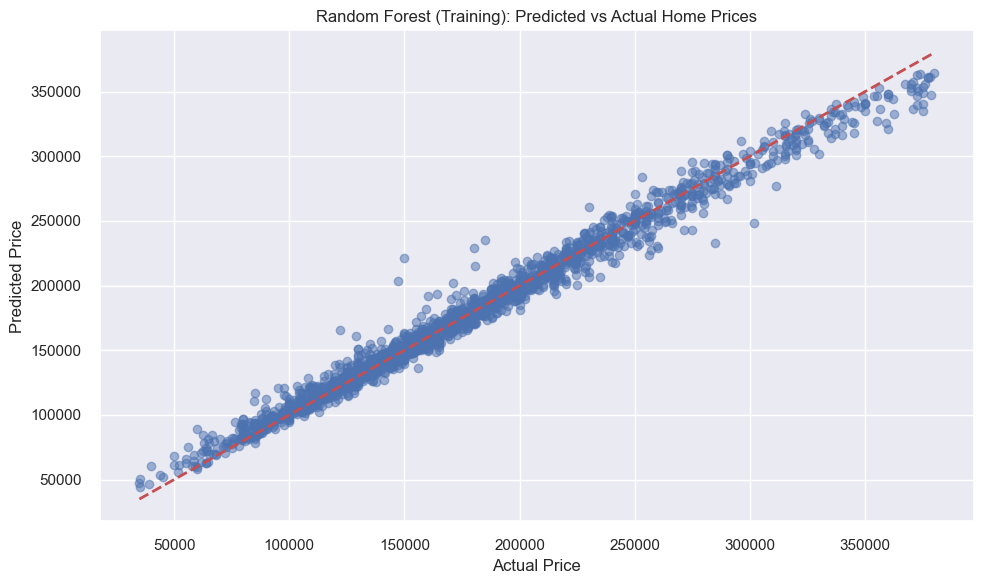


Test Set Metrics:


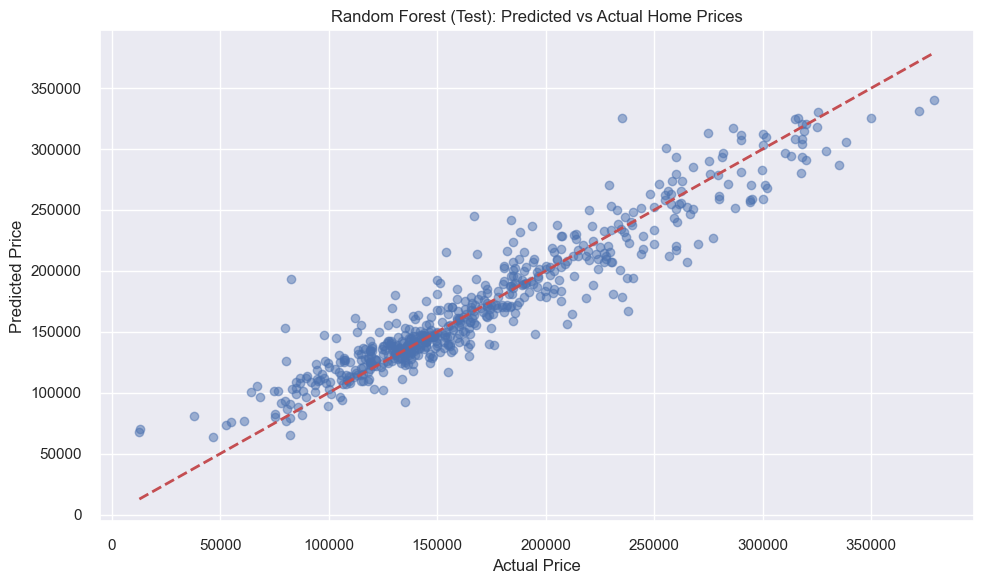


Training Set Metrics:


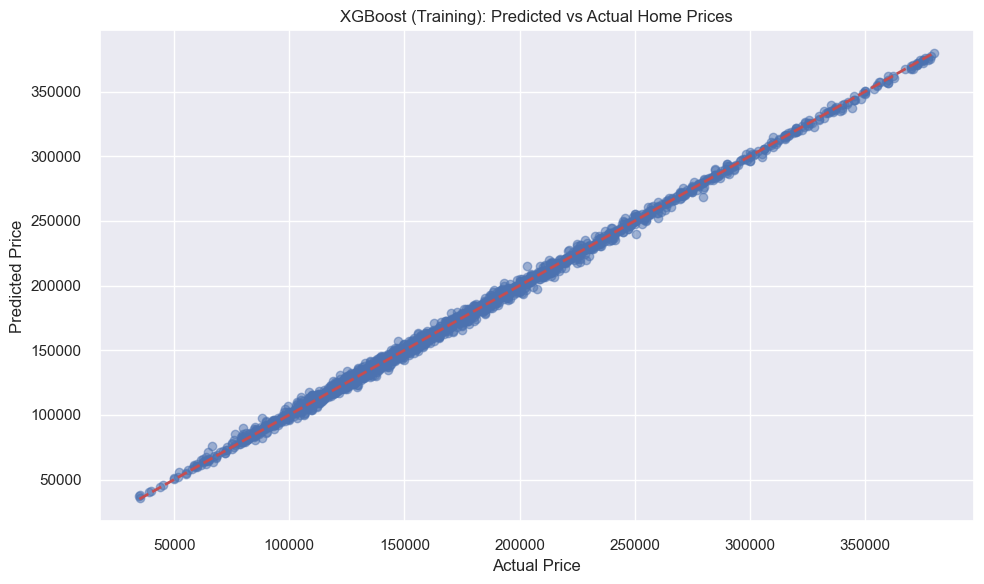


Test Set Metrics:


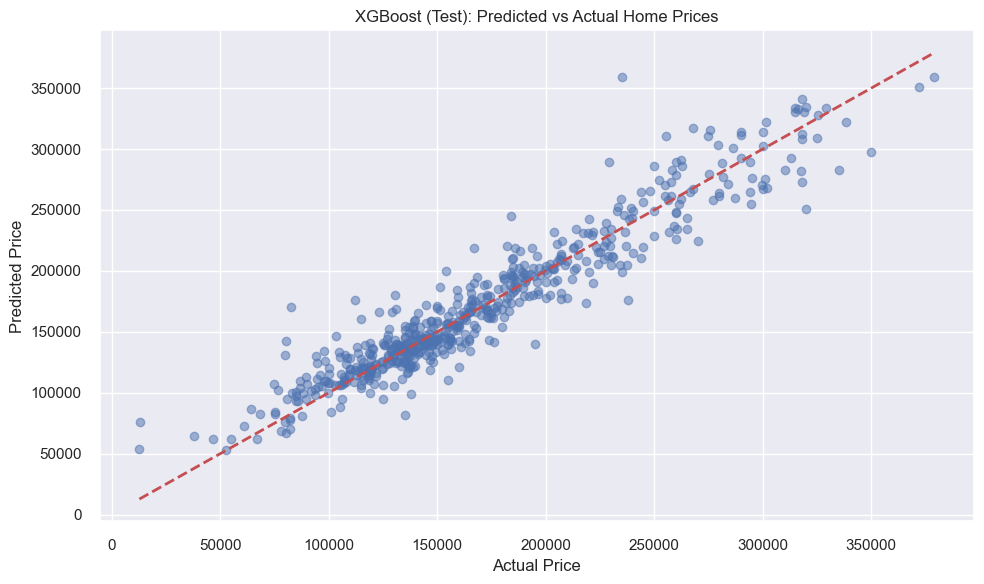

In [28]:
def plot_predictions(y_true, y_pred, model_name):
    """Create scatter plot of predicted vs actual values"""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{model_name}: Predicted vs Actual Home Prices')
    plt.tight_layout()
    plt.show()

for model_name, model in models.items():
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate on training set
    print("\nTraining Set Metrics:")
    plot_predictions(y_train, y_train_pred, f"{model_name} (Training)")
    
    # Evaluate on test set
    print("\nTest Set Metrics:")
    plot_predictions(y_test, y_test_pred, f"{model_name} (Test)")
    
    # Store results
    results[model_name] = {
        'train': train_metrics,
        'test': test_metrics
    }